# **Load libraries**

In [9]:
!pip install datashader bokeh holoviews scikit-image colorcet umap-learn

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from umap import UMAP
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg
import torch
from sklearn.manifold import TSNE
import umap.plot
from sklearn.preprocessing  import MinMaxScaler

In [11]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).

    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1:    The mean of the activations of preultimate layer of the
               CHEMNET (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2:    The mean of the activations of preultimate layer of the
               CHEMNET (like returned by the function 'get_predictions')
               for real samples.
    -- sigma1: The covariance matrix of the activations of preultimate layer
               of the CHEMNET (like returned by the function 'get_predictions')
               for generated samples.
    -- sigma2: The covariance matrix of the activations of preultimate layer
               of the CHEMNET (like returned by the function 'get_predictions')
               for real samples.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert (
        mu1.shape == mu2.shape
    ), "Training and test mean vectors have different lengths"
    assert (
        sigma1.shape == sigma2.shape
    ), "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            #raise ValueError("Imaginary component {}".format(m))
            print("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

In [ ]:
def get_w2(act1, act2):

    """Calculate w2 between two sets

    Args:
        act1: First set
        act2: Second set

    Returns:
        float: The FCD score
    """

    mu1 = np.mean(act1, axis=0)
    sigma1 = np.cov(act1.T)

    mu2 = np.mean(act2, axis=0)
    sigma2 = np.cov(act2.T)

    fcd_score = calculate_frechet_distance(
        mu1=mu1, mu2=mu2, sigma1=sigma1, sigma2=sigma2
    )

    return fcd_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **Build the plots**

In [ ]:
chain = 'H' # L / H / PAIRED
segment = 'CDR3' # CDR3 / FULL
model_name = 'prott5' # esm2 / prott5 / etc
dataset_name = f'{chain}_{segment}'

dataset_name

'H_CDR3'

In [ ]:
if model_name == 'esm2':
  data = torch.load(f'drive/MyDrive/Oslo/data/ireceptor/output/{model_name}/{dataset_name}.pt').numpy()
elif model_name == 'prott5':
  data = pd.read_pickle(f'drive/MyDrive/Oslo/data/ireceptor/output/{model_name}/{dataset_name}.pkl').values

print(len(data))

800000


In [ ]:
# Split the data into two halves
data1 = data[:len(data) // 2]
data2 = data[len(data) // 2 + 1:]

splits = [int(x) for x in [10**4, 5*10**4, 10**5, 1.5*10**5, 2*10**5, 2.5*10**5, 3*10**5, 3.5*10**5, 3.9*10**5]]
w2_data = []

num_repetitions = 10

for repetition in range(num_repetitions):
    print(repetition+1)
    w2_repetition = []

    # Shuffle data2 to ensure randomization
    np.random.shuffle(data2)

    for batch_size in splits:
        print(batch_size)
        max_start = len(data2) - batch_size
        if max_start <= 0:
            print('break')
            break
        start = np.random.randint(0, max_start)
        batch = data2[start:start + batch_size]
        w2_repetition.append(get_w2(batch, data1))
        print(get_w2(batch, data1))

    w2_data.append(w2_repetition)

# Create a DataFrame for boxplot
df = pd.DataFrame(w2_data, columns=splits)
df

1
10000
0.014368597324128984
50000
0.003150826602272616
100000
0.0017104121973137154
150000
0.0013246224047591681
200000
0.0010379284196035954
250000
0.0008922851355634975
300000
0.0008076061172719307
350000
0.0007668535057447912
390000
0.0007070936151807317
2
10000
0.014050424025821684
50000
0.0031960245506628127
100000
0.0017286405631562474
150000
0.0013202492973949376
200000
0.0010931563679950074
250000
0.0009036666678188254
300000
0.0008166824215809498
350000
0.0007604510882570636
390000
0.0007080054251451529
3
10000
0.0136365797703073
50000
0.003309867751484674
100000
0.00165916493659779
150000
0.001296135096187534
200000
0.001059285726770831
250000
0.000937384816991127
300000
0.0008280900091328647
350000
0.0007448236042728595
390000
0.0007045410404726837
4
10000
0.014277802063026535
50000
0.002982734614734639
100000
0.0018138038159412062
150000
0.0012915785256240042
200000
0.0010315064872497004
250000
0.0008942556605626706
300000
0.0008097272646097053
350000
0.0007434902831189305

,10000,50000,100000,150000,200000,250000,300000,350000,390000
0,0.014369,0.003151,0.001710,0.001325,0.001038,0.000892,0.000808,0.000767,0.000707
1,0.014050,0.003196,0.001729,0.001320,0.001093,0.000904,0.000817,0.000760,0.000708
2,0.013637,0.003310,0.001659,0.001296,0.001059,0.000937,0.000828,0.000745,0.000705
3,0.014278,0.002983,0.001814,0.001292,0.001032,0.000894,0.000810,0.000743,0.000710
4,0.013731,0.003091,0.001814,0.001313,0.001094,0.000896,0.000802,0.000748,0.000705
5,0.013876,0.002984,0.001756,0.001279,0.001038,0.000923,0.000806,0.000766,0.000713
6,0.014254,0.003093,0.001749,0.001288,0.001030,0.000911,0.000819,0.000751,0.000709
7,0.013712,0.003446,0.001704,0.001338,0.001054,0.000915,0.000815,0.000747,0.000703
8,0.013629,0.003104,0.001779,0.001275,0.001043,0.000909,0.000811,0.000739,0.000703
9,0.013676,0.003083,0.001703,0.001275,0.001031,0.000898,0.000796,0.000748,0.000704


In [ ]:
df = df.drop(df.columns[0], axis=1)
df

,50000,100000,150000,200000,250000,300000,350000,390000
0,0.003151,0.001710,0.001325,0.001038,0.000892,0.000808,0.000767,0.000707
1,0.003196,0.001729,0.001320,0.001093,0.000904,0.000817,0.000760,0.000708
2,0.003310,0.001659,0.001296,0.001059,0.000937,0.000828,0.000745,0.000705
3,0.002983,0.001814,0.001292,0.001032,0.000894,0.000810,0.000743,0.000710
4,0.003091,0.001814,0.001313,0.001094,0.000896,0.000802,0.000748,0.000705
5,0.002984,0.001756,0.001279,0.001038,0.000923,0.000806,0.000766,0.000713
6,0.003093,0.001749,0.001288,0.001030,0.000911,0.000819,0.000751,0.000709
7,0.003446,0.001704,0.001338,0.001054,0.000915,0.000815,0.000747,0.000703
8,0.003104,0.001779,0.001275,0.001043,0.000909,0.000811,0.000739,0.000703
9,0.003083,0.001703,0.001275,0.001031,0.000898,0.000796,0.000748,0.000704


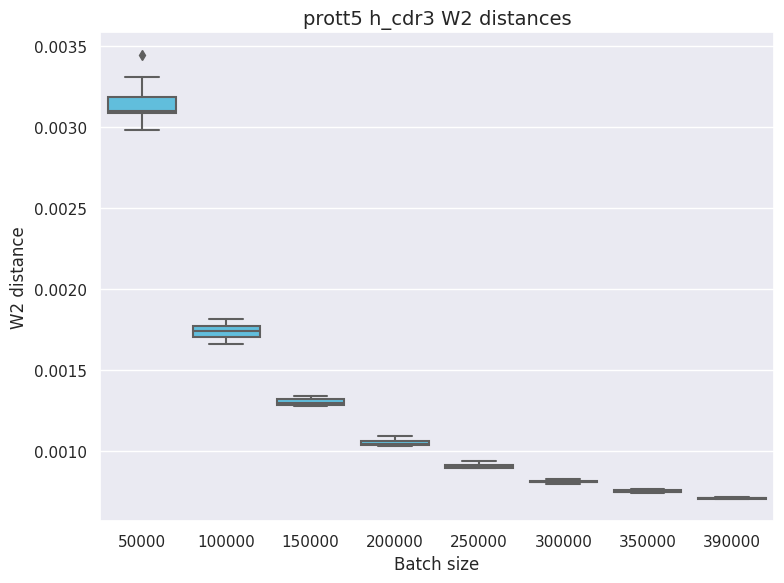

In [ ]:
# Create a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, orient="v", color='#4CC9F0')
plt.title(f'{model_name} {dataset_name.lower()} W2 distances', fontsize=14)
plt.xlabel('Batch size', fontsize=12)
plt.ylabel('W2 distance', fontsize=12)
#plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(f'{model_name}_W2_{dataset_name}.png')
plt.show()

# **Test section**

In [18]:
df1 = torch.load(f'drive/MyDrive/Oslo/data/paper/output/esm2/RANDOM_H_CDR3.pt').numpy()
print(len(df1))
df1

794620


array([[ 0.05024647,  0.0586454 ,  0.1327793 , ...,  0.02057763,
        -0.03630046,  0.07561572],
       [ 0.04298138,  0.06602933,  0.10780355, ..., -0.08737174,
        -0.06264061, -0.00161236],
       [ 0.01422979,  0.03269802,  0.07703374, ..., -0.00987368,
        -0.03762759,  0.00524085],
       ...,
       [ 0.08150401,  0.05967524,  0.12981704, ...,  0.00228762,
        -0.04507056,  0.00645562],
       [ 0.08131534,  0.02465722,  0.1871686 , ...,  0.03231465,
        -0.1193441 ,  0.02284576],
       [-0.01483671,  0.1423709 ,  0.04472488, ..., -0.0872823 ,
        -0.09243376,  0.03025006]], dtype=float32)

In [19]:
df2 = torch.load(f'drive/MyDrive/Oslo/data/paper/output/esm2/random_aa_matrix_H_CDR3.pt').numpy()
print(len(df2))
df2

794605


array([[-0.01963385,  0.15221515,  0.07607701, ..., -0.03386929,
         0.00088481,  0.0231742 ],
       [-0.00229889,  0.13334529, -0.01683373, ..., -0.07158045,
        -0.0105847 , -0.08904233],
       [-0.01416569,  0.14558166,  0.08803541, ...,  0.04282766,
        -0.03532982,  0.02786414],
       ...,
       [-0.01561345,  0.04132407,  0.07161749, ...,  0.04675549,
         0.0319206 ,  0.08787932],
       [-0.0117556 ,  0.11266162,  0.07069651, ..., -0.02287345,
        -0.02815187,  0.00740201],
       [ 0.0057015 ,  0.11167002,  0.06576971, ...,  0.00529654,
         0.03260115,  0.04483802]], dtype=float32)

In [20]:
df3 = torch.load(f'drive/MyDrive/Oslo/data/paper/output/esm2/H_CDR3.pt').numpy()
print(len(df3))
df3

794620


array([[-0.02020066,  0.08459156,  0.05958994, ..., -0.07105227,
        -0.09129159, -0.00263326],
       [ 0.00831061,  0.13440327,  0.0034655 , ..., -0.03348783,
        -0.03252514, -0.05293455],
       [ 0.08818718,  0.1490144 ,  0.04663053, ..., -0.07051066,
        -0.06373546, -0.1257977 ],
       ...,
       [-0.01463528,  0.09401029,  0.13765444, ..., -0.00680104,
        -0.02362252,  0.06941637],
       [-0.01586834,  0.05974891,  0.08116592, ..., -0.00900307,
        -0.01945676, -0.02241864],
       [-0.01466096,  0.08186734,  0.0878448 , ..., -0.02419284,
        -0.01692966, -0.00076429]], dtype=float32)

In [21]:
df4 = torch.load(f'drive/MyDrive/Oslo/data/ireceptor/output/esm2/H_CDR3_no_flanking.pt').numpy()
print(len(df4))
df4

800000


array([[-0.02294354,  0.10829616, -0.00790158, ..., -0.01976356,
        -0.05056135,  0.0037635 ],
       [-0.11323807,  0.03886104,  0.06295092, ..., -0.02789772,
        -0.02761861,  0.07673842],
       [ 0.000586  ,  0.11198122,  0.05324382, ..., -0.01538158,
        -0.10668137, -0.01746716],
       ...,
       [ 0.02377634,  0.13426693,  0.19977432, ...,  0.08127326,
        -0.08765472, -0.01026705],
       [-0.0231177 ,  0.08797988,  0.11202578, ...,  0.00177373,
        -0.0270088 , -0.03078796],
       [-0.05419089,  0.06614098,  0.07452241, ..., -0.00546991,
         0.0078072 ,  0.05490636]], dtype=float32)

## **W2 matrix**

In [22]:
# Initialize a list to store distance matrices
distance_matrices = []

# List of dataset variables
datasets = [df1, df2, df3, df4]

# Calculate distance matrices for all unique combinations of datasets
n_datasets = len(datasets)
for i in range(n_datasets):
    for j in range(i, n_datasets):
        dist_matrix = get_w2(datasets[i], datasets[j])
        distance_matrices.append(dist_matrix)

In [ ]:
get_w2(df3, df4)

0.962083499884117

In [ ]:
get_w2(df2, df3)

0.10782125984112678

In [ ]:
distance_matrices

[-6.926619278146973e-10,
 1.448677607529973,
 1.6557365383175906,
 1.6127211770916299,
 2.042810365310288e-13,
 0.10782125984112678,
 1.072610729133709,
 -4.935882813583703e-10,
 0.962083499884117,
 -7.59833973518198e-10]

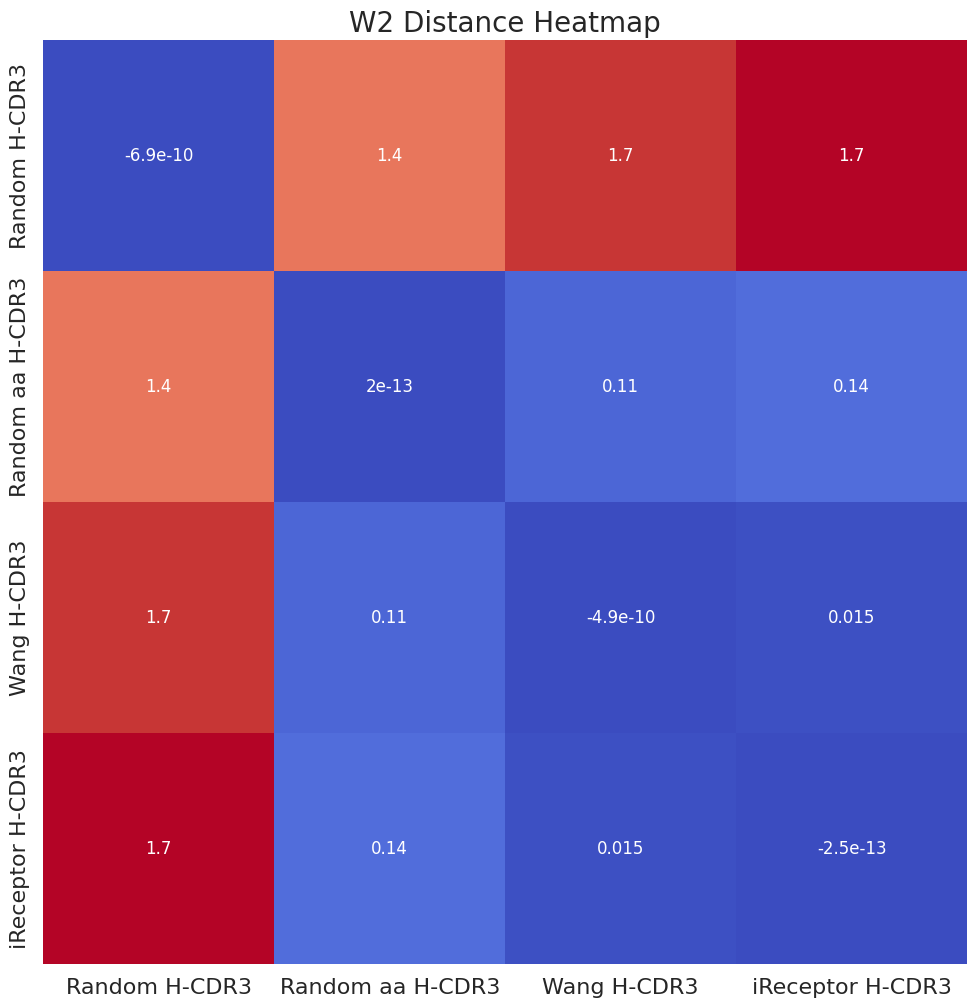

In [23]:
from scipy.spatial.distance import squareform


# Create a square heatmap
fig, ax = plt.subplots(figsize=(12, 12))

# Create the combined distance matrix for the square heatmap
combined_matrix = np.zeros((n_datasets, n_datasets))
idx = 0
for i in range(n_datasets):
    for j in range(i, n_datasets):
        combined_matrix[i, j] = distance_matrices[idx]
        combined_matrix[j, i] = combined_matrix[i, j]
        idx += 1

# Create the heatmap
sns.heatmap(combined_matrix, cmap="coolwarm", annot=True, cbar=False, square=True)

# Customize the labels
ax.set_xticklabels(['Random H-CDR3', 'Random aa H-CDR3', 'Wang H-CDR3', 'iReceptor H-CDR3'], fontsize=16)
ax.set_yticklabels(['Random H-CDR3', 'Random aa H-CDR3', 'Wang H-CDR3', 'iReceptor H-CDR3'], fontsize=16)
ax.set_title("W2 Distance Heatmap", fontsize=20)

plt.savefig('w2_heatmap')

# Show the heatmap
plt.show()

## **Clustering**

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing  import MinMaxScaler

In [ ]:
np.random.seed(42)

num_samples = 500000

#df1_sub = df1[np.random.choice(df1.shape[0], num_samples, replace=False)]
#df2_sub = df2[np.random.choice(df2.shape[0], num_samples, replace=False)]
#df3_sub = df3[np.random.choice(df3.shape[0], num_samples, replace=False)]
#df4_sub = df4[np.random.choice(df4.shape[0], num_samples, replace=False)]

df_sub = df[np.random.choice(df.shape[0], num_samples, replace=False)]

print(len(df_sub))
df_sub

500000


array([[ 0.14085868,  0.1093783 ,  0.10440329, ..., -0.0017226 ,
        -0.04328247, -0.02952321],
       [-0.00754594,  0.10055795,  0.06373975, ...,  0.09532163,
        -0.06829903,  0.06409438],
       [ 0.08089745,  0.0754693 ,  0.14188017, ..., -0.0029397 ,
        -0.01572815,  0.05567513],
       ...,
       [ 0.05785454,  0.16363065,  0.09452904, ...,  0.00245532,
        -0.05871434, -0.0208669 ],
       [ 0.06574874,  0.07535756,  0.19771054, ..., -0.00547698,
        -0.13159288,  0.02830367],
       [ 0.08996585,  0.09755068,  0.14290756, ...,  0.04349941,
        -0.061415  , -0.04254688]], dtype=float32)

In [ ]:
X = df_sub

scaler = MinMaxScaler()
scaler.fit(X)
X_norm = scaler.transform(X)

X_norm

array([[0.7733073 , 0.63586473, 0.5685283 , ..., 0.47895643, 0.5677212 ,
        0.38873732],
       [0.41308123, 0.613402  , 0.4684319 , ..., 0.634042  , 0.52227753,
        0.5443709 ],
       [0.62776196, 0.5495088 , 0.66078055, ..., 0.47701138, 0.6177748 ,
        0.5303744 ],
       ...,
       [0.5718294 , 0.77402896, 0.5442221 , ..., 0.48563313, 0.5396885 ,
        0.4031279 ],
       [0.59099114, 0.54922426, 0.79821134, ..., 0.4729566 , 0.4073015 ,
        0.48487103],
       [0.64977396, 0.6057434 , 0.6633096 , ..., 0.55122536, 0.53478265,
        0.36708626]], dtype=float32)

In [ ]:
tsne_data = TSNE(random_state=42).fit_transform(X_norm) # X_norm
tsne_df = pd.DataFrame(tsne_data)

In [ ]:
umap_df = pd.DataFrame(UMAP(transform_seed=42).fit_transform(X_norm))

In [ ]:
reducer = UMAP(densmap=False,
               transform_seed=42)

embedding = reducer.fit_transform(X_norm)

umap_df = pd.DataFrame(embedding)

SystemError: ignored

In [ ]:
umap.plot.connectivity(reducer)

In [ ]:
dbscan = DBSCAN(eps=4, min_samples=4, metric='euclidean')

labels = dbscan.fit_predict(X_norm)

np.unique(labels)

array([-1,  0,  1,  2,  3,  4])

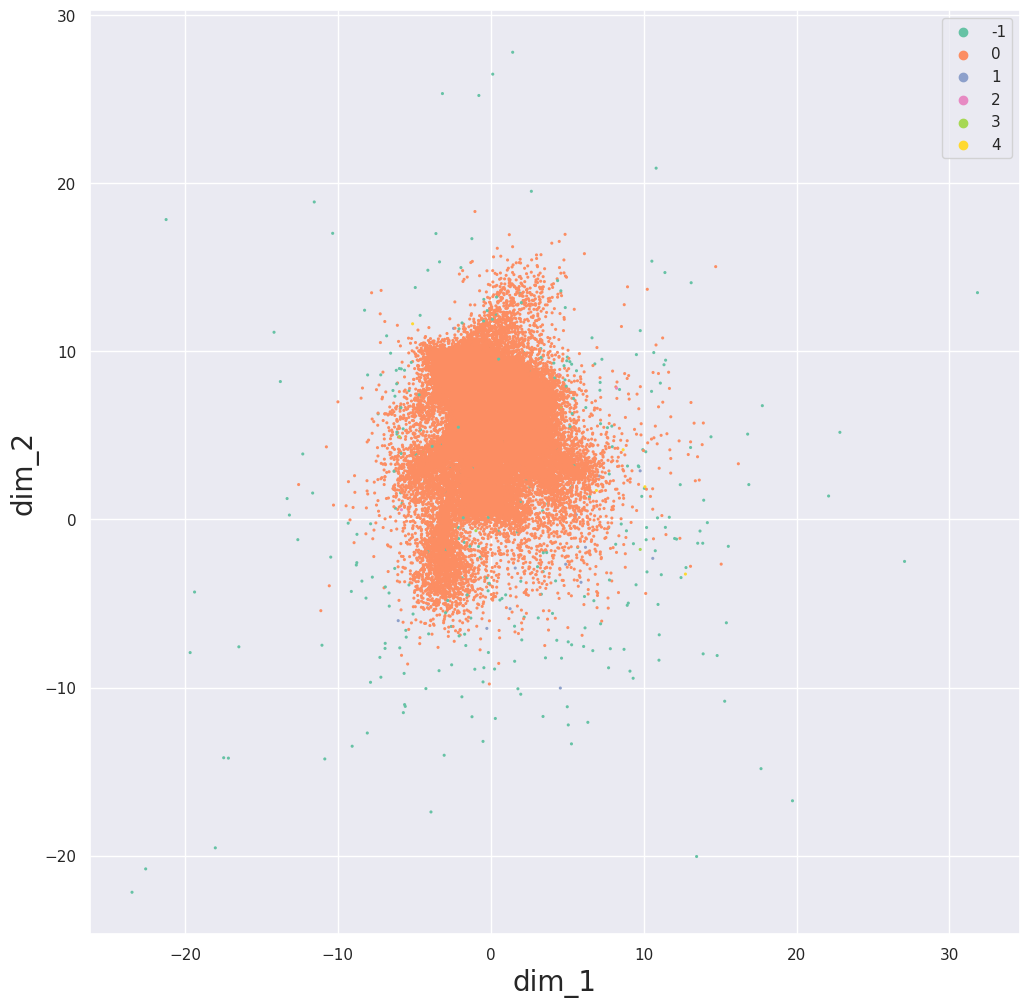

In [ ]:
data = umap_df

plt.figure(figsize=(12, 12))
scatter = sns.scatterplot(data=data, x=data.iloc[:,0].values, y=data.iloc[:,1].values, s=5, linewidth=0, hue=labels, palette="Set2")
plt.xlabel('dim_1', fontsize=20)
plt.ylabel('dim_2', fontsize=20)
plt.savefig(f'4')

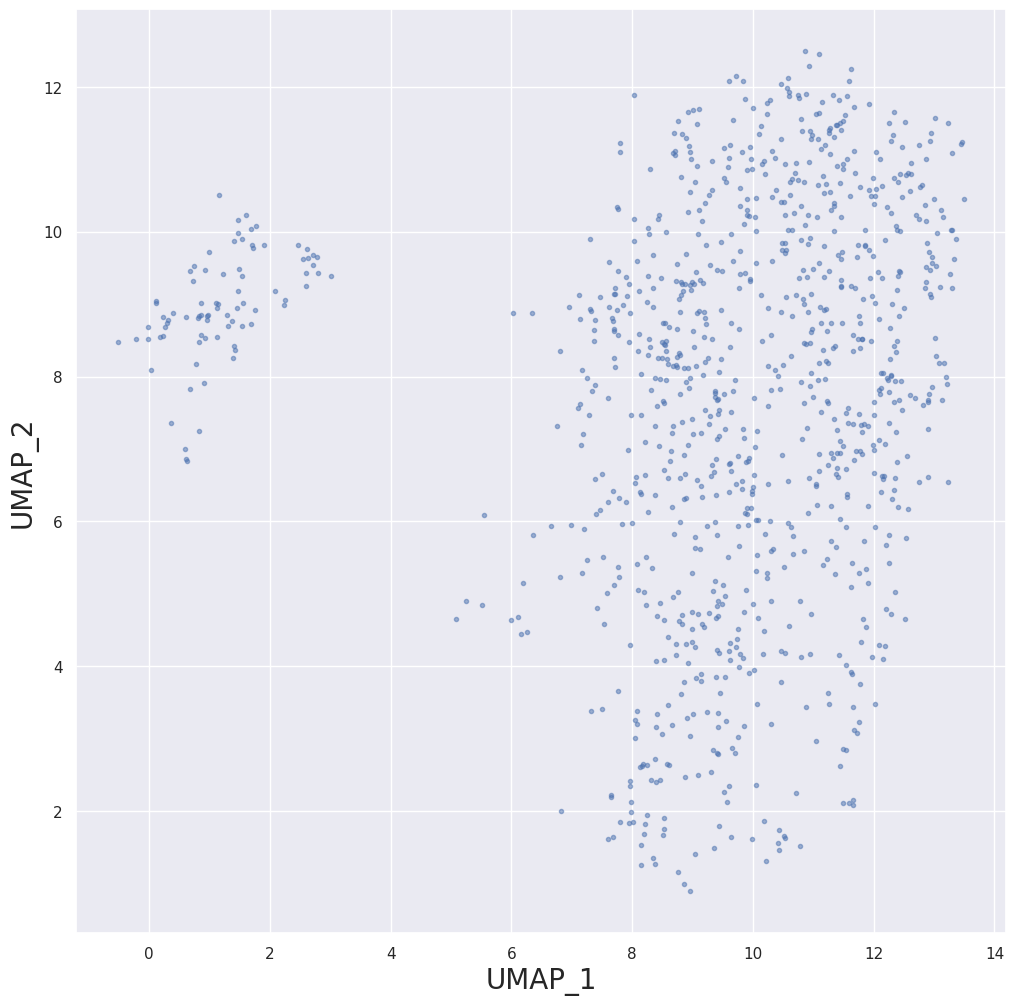

In [ ]:
plt.figure(figsize=(12, 12))
plt.scatter(umap_df[0:1000].iloc[:,0].values, umap_df[0:1000].iloc[:,1].values, marker='.', color='b', alpha=0.5)
#plt.title('UMAP Projection')
plt.xlabel('UMAP_1', fontsize=20)
plt.ylabel('UMAP_2', fontsize=20)
plt.savefig('{}.png'.format('umap_esm2_hcdr3_1000'))
plt.show()

## **ProtT5 embeddings**

In [ ]:
data = pd.read_pickle('drive/MyDrive/Oslo/embeddings/prott5/H_CDR3.pkl').values
data

array([[ 1.38557121e-01,  3.81311327e-02, -3.23420949e-02, ...,
         1.93450272e-01, -5.78124933e-02, -4.74567860e-02],
       [ 7.40994811e-02,  8.15188736e-02, -9.50117484e-02, ...,
         1.25256181e-01, -4.49098088e-02, -6.99433982e-02],
       [ 1.16386116e-01,  4.54737246e-02, -6.97857663e-02, ...,
         6.54706657e-02, -3.63494530e-02, -5.72018027e-02],
       ...,
       [ 8.47983360e-02,  2.08725333e-02, -8.45328197e-02, ...,
         7.77046308e-02, -1.30868575e-04, -1.53598404e-02],
       [ 1.20014280e-01,  2.16536261e-02, -1.18533269e-01, ...,
         8.87460560e-02,  1.99058615e-02, -4.24111336e-02],
       [ 1.01903781e-01, -1.90236028e-02, -9.63438973e-02, ...,
         8.92564431e-02,  1.25142969e-02, -2.98409164e-02]], dtype=float32)

In [ ]:
len(data)

794620

In [ ]:
data1 = data[0 : int(len(data)/2)]
data2 = data[int(len(data)/2+1):len(data)]

batches = []
w2 = []

splits = [10**3, 10**4, 3*10**4, 5*10**4, 8*10**4, 10**5, 2*10**5, 3*10**5]
for el in splits:
  batches.append(data2[0:el])

for el in batches:
  print(len(el))
  w2.append(get_w2(el, data1))

1000
10000
30000
50000
80000
100000
200000
300000


In [ ]:
w2

[0.18387881490872093,
 0.021557216678845137,
 0.011102310533550153,
 0.009658446144171329,
 0.009634472776220981,
 0.00938045615928118,
 0.004874846589068227,
 0.006433137884052087]

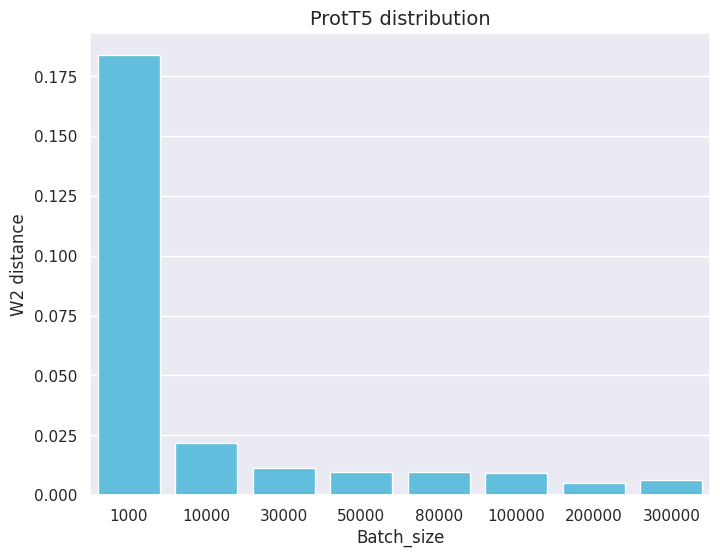

In [ ]:
df = pd.DataFrame({'len': splits, 'w2': w2})

plt.figure(figsize=(8, 6))

sns.barplot(data=df, x="len", y="w2", color='#4CC9F0')

plt.title('ProtT5 distribution', fontsize=14)
plt.xlabel('Batch_size')
plt.ylabel('W2 distance')
plt.savefig('{}.png'.format('prott5_hcdr3'))
plt.show()

In [ ]:
umap_df = pd.DataFrame(pd.read_pickle('drive/MyDrive/Oslo/embeddings/prott5/UMAP_H_CDR3.pkl').values)
umap_df

,0,1
0,-2.136829,10.450885
1,2.089752,9.962424
2,2.249510,10.643735
3,0.375735,16.552591
4,1.611571,11.477965
...,...,...
794615,0.204666,7.385293
794616,-1.904247,8.445482
794617,0.542923,9.726994
794618,-2.028817,9.892709


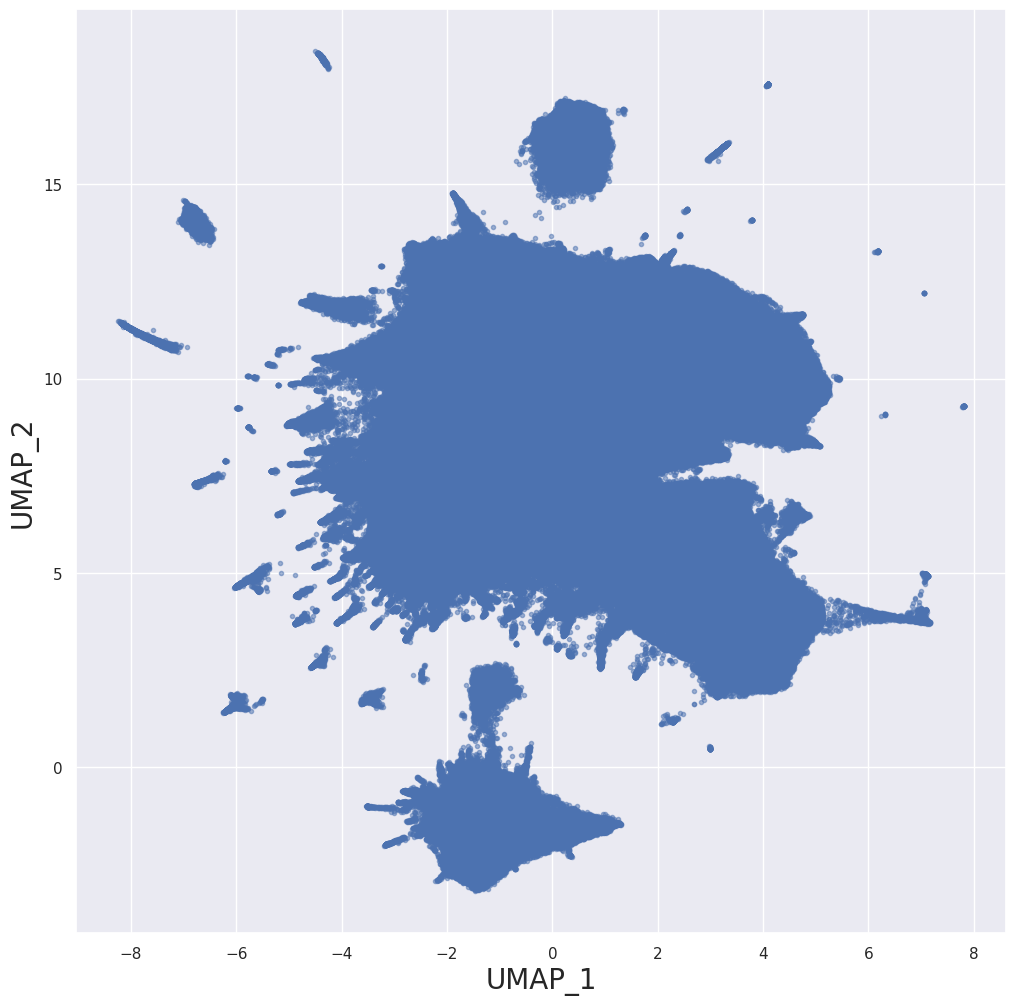

In [ ]:
plt.figure(figsize=(12, 12))
plt.scatter(umap_df.iloc[:,0].values, umap_df.iloc[:,1].values, marker='.', color='b', alpha=0.5)
#plt.title('UMAP Projection')
plt.xlabel('UMAP_1', fontsize=20)
plt.ylabel('UMAP_2', fontsize=20)
plt.savefig('{}.png'.format('umap_prott5_hcdr3_all'))
plt.show()

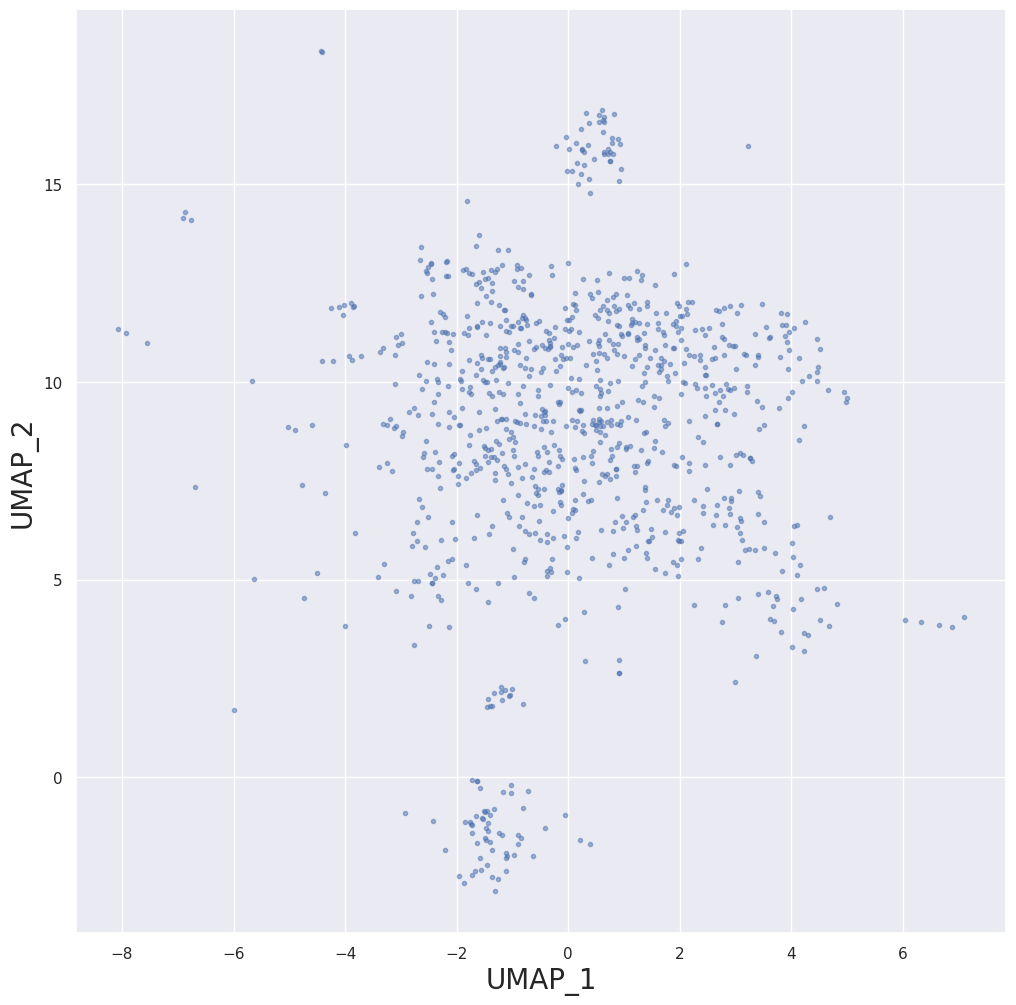

In [ ]:
plt.figure(figsize=(12, 12))
plt.scatter(umap_df[0:1000].iloc[:,0].values, umap_df[0:1000].iloc[:,1].values, marker='.', color='b', alpha=0.5)
#plt.title('UMAP Projection')
plt.xlabel('UMAP_1', fontsize=20)
plt.ylabel('UMAP_2', fontsize=20)
plt.savefig('{}.png'.format('umap_prott5_hcdr3_1000'))
plt.show()

# **Build UMAPs**

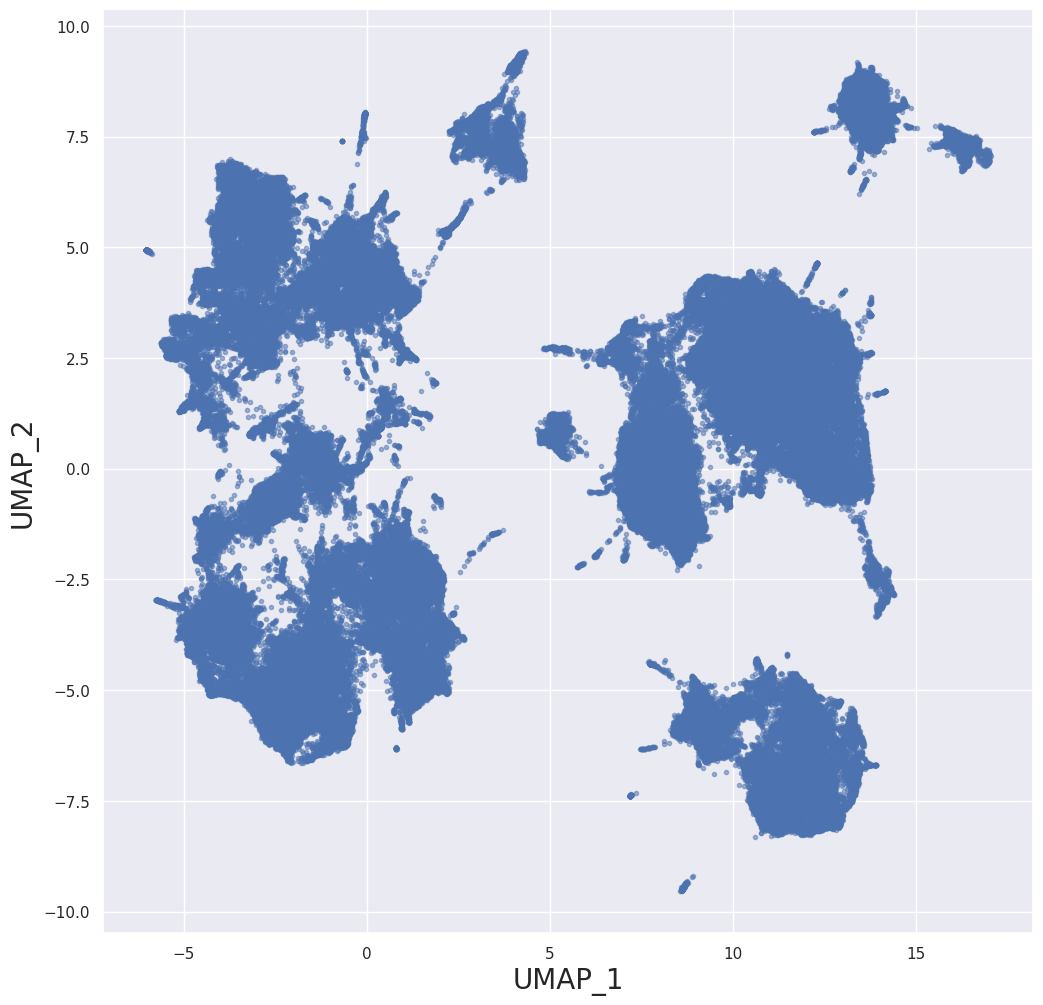

In [ ]:
umap_df = pd.DataFrame(UMAP(transform_seed=42).fit_transform(data))

plt.figure(figsize=(12, 12))
plt.scatter(umap_df.iloc[:,0].values, umap_df.iloc[:,1].values, marker='.', color='b', alpha=0.5)
#plt.title('UMAP Projection')
plt.xlabel('UMAP_1', fontsize=20)
plt.ylabel('UMAP_2', fontsize=20)
plt.savefig('{}.png'.format('prott5_umap1'))
plt.show()

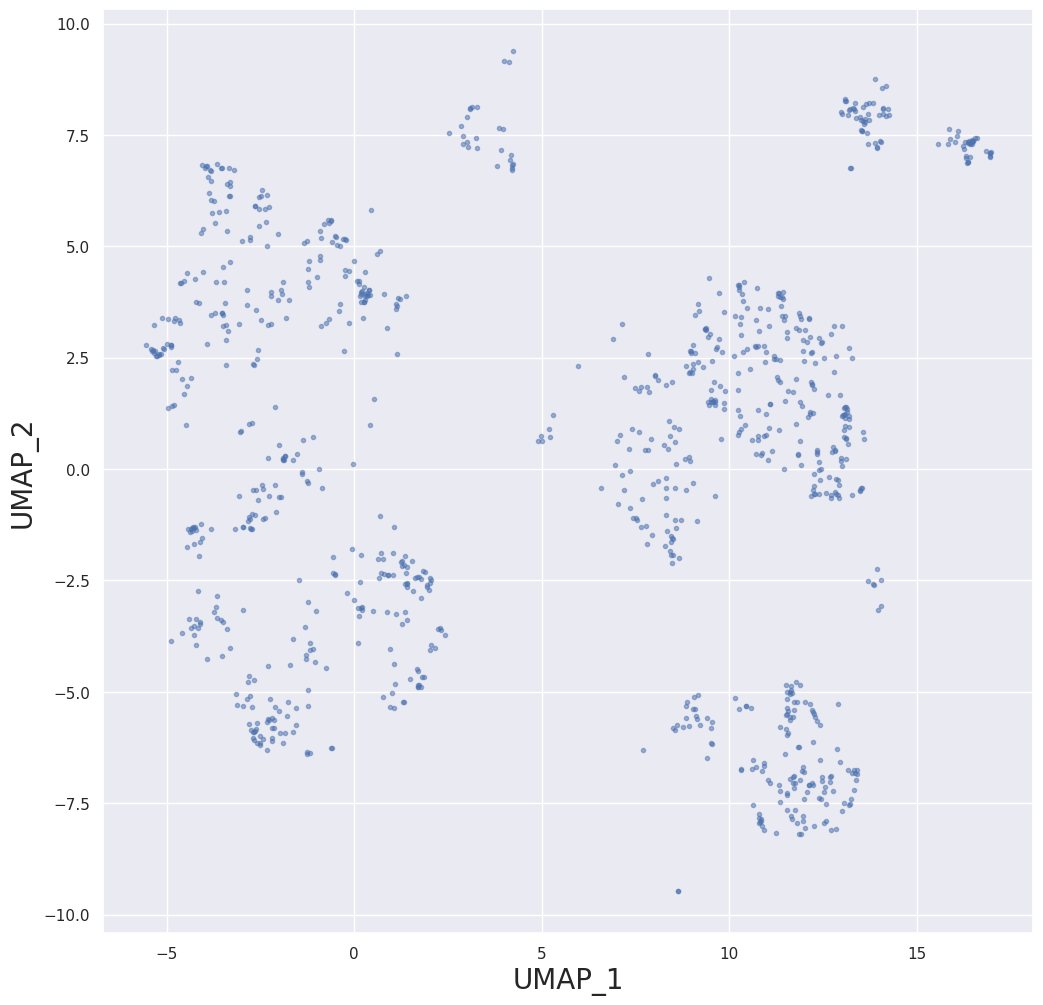

In [ ]:
umap_df[0:30000]

plt.figure(figsize=(12, 12))
plt.scatter(umap_df[0:1000].iloc[:,0].values, umap_df[0:1000].iloc[:,1].values, marker='.', color='b', alpha=0.5)
#plt.title('UMAP Projection')
plt.xlabel('UMAP_1', fontsize=20)
plt.ylabel('UMAP_2', fontsize=20)
#plt.ylim(-10, 20)
plt.savefig('{}.png'.format('prott5_umap3'))
plt.show()